### Big Data Analytics

**Project 01**

**Zakaria Alsahfi**

### Project Description

In this project, you will be working with a dataset containing several million movie ratings collected from the movie recommendation website [MovieLens](https://movielens.org/). The ratings were collected over a period of several years starting in January 1995. You will be asked to create a bar chart showing the distribution of the movie ratings, as well as find the movies with the most ratings, and the movies with the highest average rating. 

It is intended that you will work with RDDs (and not DataFrames) for this project. Future projects will provide you with opportunities to work with DataFrames.

### Part A: Getting Started

#### Obtaining the Data

You can download the dataset by clicking on the following link: [ml-latest.zip](http://files.grouplens.org/datasets/movielens/ml-latest.zip) (size: 265 MB). After the download has completed, please extract the zip file, and then upload the file **ratings.csv** to DataBricks. I recommend creating a new folder called **movie_lens** to store the data for this project. You can do this by simply typing the name of the folder in the text box that follows the path **``/FileStore/tables/``**. See the image below. 

![Apache Spark](https://drbeane.github.io/files/images/movie_lens.jpg)

The file **movies.csv** contains the names of the movies, which we will also need. However, this is a comma-separated file, and many of the movie names contain commas. I have created a tab-delimited version of this file named **movies.txt**. You can download it from [Canvas](https://maryville.instructure.com/courses/37743/files/folder/data). Please upload this file to DataBricks, placing it in the folder you created previously.

#### Creating a SparkContext

In the cell below, import `SparkSession` from `pyspark.sql`. Also import `numpy` under the alias `np`, and `matplotlib.pyplot` as `plt`. Then create `SparkSession` and `SparkContext` objects.

In [0]:
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

### Part B: Reading and Processing Data Files

In the cell below, read the contents of the file `ratings.csv` into an RDD named `ratings_raw`. Then read in the contents of the file `movies.txt` into an RDD named `movies_raw`.

In [0]:
ratings_raw = sc.textFile('/FileStore/tables/movie_lens/ratings.csv')
movies_raw = sc.textFile('/FileStore/tables/movies.txt')

In the cell below, use `take()` to obtain the first 5 entries of `ratings_raw`. Use a loop to print these entries. 

You should notice that the first row contains header information. The remaining rows contain the following information for each rating: The **`userId`** of the user who submitted the rating, the **`movieId`** of the movie being rated, the **`rating`** that was submitted (on a scale from 0 to 5 stars, with half-star ratings allowed), and a **`timestamp`** noting when the rating was submitted.

In [0]:
for row in ratings_raw.take(5):
  print(row)

userId,movieId,rating,timestamp
1,307,3.5,1256677221
1,481,3.5,1256677456
1,1091,1.5,1256677471
1,1257,4.5,1256677460

In the cell below, use `take()` to obtain the first 5 entries of `movies_raw`. Use a loop to print these entries. 

You should notice that the first row contains header information. The remaining rows contain the following information for each movie: The **`movieId`** of the movie, the **`title`** of the movie, and a list of **`genres`** for the movie.

In [0]:
for row in movies_raw.take(5):
  print(row)

movieId	title	genres
1	Toy Story (1995)	Adventure|Animation|Children|Comedy|Fantasy
2	Jumanji (1995)	Adventure|Children|Fantasy
3	Grumpier Old Men (1995)	Comedy|Romance
4	Waiting to Exhale (1995)	Comedy|Drama|Romance

Filter out the first row of each RDD, storing the results back into variables with the same names as the previous RDDs.

In [0]:
ratings_raw = ratings_raw.filter(lambda x : 'userId' not in x)
movies_raw = movies_raw.filter(lambda x : 'movieId' not in x)

In the cell below create two functions: one named **`process_rating`**, and one named **`process_movie`**. These functions will be used to parse the lines of the RDDs we have already created. The functions should each split the RDDs lines at the relevant delimiter (commas for `ratings_raw` and tabs for `movies_raw`). 

The `process_rating` function should return a tuple that consists of `movieId` (as an `int`) and `rating` (as a `float`). We will not need the other pieces of information in this project. The `process_movie` function should return a tuple that consists of `movieId` (as an `int`) and `title` (as a `str`).

In [0]:
def process_rating(line):
  elems = line.split(",")
  return (int(elems[1]), float(elems[2]))

def process_movie(line):
  elems = line.split("\t")
  return (int(elems[0]), elems[1])

Apply the two functions above to the elements of the relevant RDDs. Store the results in two new RDDs names `ratings` and `movies`.

In [0]:
ratings = ratings_raw.map(process_rating)
movies = movies_raw.map(process_movie)

Use a loop to print the first 5 elements of `ratings`, with each element on its own line.

In [0]:
for elem in ratings.take(5):
  print(elem)

(307, 3.5)
(481, 3.5)
(1091, 1.5)
(1257, 4.5)
(1449, 4.5)

Use a loop to print the first 5 elements of `movies`, with each element on its own line.

In [0]:
for elem in movies.take(5):
  print(elem)

(1, 'Toy Story (1995)')
(2, 'Jumanji (1995)')
(3, 'Grumpier Old Men (1995)')
(4, 'Waiting to Exhale (1995)')
(5, 'Father of the Bride Part II (1995)')

Persist the `ratings` RDD. Then print the number of elements in this RDD.

In [0]:
ratings = ratings.persist()
print(ratings.count())

27753444

The cell below collects the `movies` RDD, and then converts the resulting list into a dictionary. We can use this dictionary as a lookup table to find the name of a movie based on its `movieId`.

In [0]:
movie_dict = dict(movies.collect())

### Part C: Creating Bar Chart of Ratings

In the cell below, write code to create a pair RDD called `star_counts`. The key for this RDD should be a particular score (0.5, 1.0, 1.5, etc.). The value should be a count of the number of times that a particular score was submitted in a review. This RDD should be sorted by the key, in ascending order. **Note:** It will likely require a few steps to produce this RDD. 

After creating `star_counts`, create two lists called `ratings_list` and `counts_list`. These lists should be generated by collecting the RDD of keys and the RDD of values in `star_counts`. The transformations `keys()` and `values()` will be helpful for this. 

Print `ratings_list` and `counts_list`.

In [0]:
step1 = ratings.map(lambda x: (x[1], 1))
step2 = step1.sortBy(lambda x : x[0], ascending=True)
star_counts = step2.countByKey()
ratings_list = []
counts_list = []
for key in star_counts:
  ratings_list.append(key)
  counts_list.append(star_counts[key])

print(ratings_list)
print(counts_list)

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
[442388, 886233, 441354, 1850627, 1373419, 5515668, 3404360, 7394710, 2373550, 4071135]

When displaying our bar chart, we will want to have proportions displayed on the vertical axis rather than counts. To achieve this, coerce `counts_list` into a numpy array called `counts_array`. Then create an array called `prop_array` by dividing `counts_array` by the sum of its elements. Print `prop_array`.

In [0]:
counts_array = np.array(counts_list)
prop_array = counts_array / sum(counts_array)
print(prop_array)

[0.01593993 0.03193236 0.01590267 0.06668099 0.04948643 0.19873815
 0.12266442 0.26644297 0.08552272 0.14668936]

In the code provided below, replace the blanks so that the resulting bar chart will show star ratings along the horizontal axis, and the bars heights will be determined by the proportion of reviews that awarded that particular score. Also, select a [named color](https://matplotlib.org/3.1.0/gallery/color/named_colors.html) for the bars in the plot.

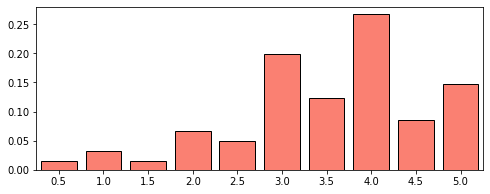

In [0]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 10})

plt.close()
plt.figure(figsize=[8,3])
plt.bar(range(10), height=prop_array, tick_label=ratings_list, align='center', color='salmon', edgecolor='k')
plt.xlim(-0.5, 9.5)
plt.show()

You should notice that the half-star ratings seem to be used less frequently than whole-star ratings. However, if we searched the dataset for the earliest review that gave a half-star rating, we would see that it was given in February 2003, despite the reviews in general going back to January 1995. It would seem that MovieLens did not originally allow half-star ratings, which likely explains why fewer of these ratings were given.

### Part D: Determine Most Popular Movies

We will now turn our attention to finding the movies that have been reviewed the greatest number of times, as well as the movies with the highest average ratings. I recommend approaching this problem as follows:

1. Start with the `ratings` RDD, whose elements are of the form: `(movieId, rating)`
2. Create an RDD called `ratings_expanded` whose elements are of the form: `(movieId, (rating, 1))`
3. Perform a `reduceByKey()` to create an RDD called `totals_by_movie` whose elements are of the form: `(moviId, (sumOfRatings, countOfRatings))`
4. Use `totals_by_move` to create an RDD called `summary` and whose elements are of the form: `(moviId, (sumOfRatings, countOfRatings, avgRating))`

Print the first 5 elements of `summary`.

In [0]:
ratings_expanded = ratings.mapValues(lambda x: (x,1))
totals_by_movie = ratings_expanded.reduceByKey(lambda x,y: (x[0] + y[0], x[1] + y[1]))
summary = totals_by_movie.mapValues(lambda x: (x[0],x[1],(x[0] / x[1])))
print(summary.take(5))

[(1296, (29089.5, 7470, 3.8941767068273094)), (2352, (27964.5, 7517, 3.720167620061195)), (828, (5464.0, 1736, 3.1474654377880182)), (960, (604.0, 173, 3.491329479768786)), (2028, (218838.0, 54027, 4.05053029041035))]

We will now find the 20 most frequently reviewed movies. Sort `summary` by number of reviews, in decreasing order, and then take the first 20 results from this RDD. For each of these movies, print the number of reviews, followed by a tab, and then the title of the movie. Two print statements are already provided for you to provide a header for your results.

In [0]:
print('Count', '\t', 'Title')
print('----------------------------------------------')
summary_number_of_reviews = summary.sortBy(lambda x : x[1][1], ascending=False)
for row in summary_number_of_reviews.take(20):
  print(row[1][1],'\t', movie_dict[row[0]])

Count Title
----------------------------------------------
97999 Shawshank Redemption, The (1994)
97040 Forrest Gump (1994)
92406 Pulp Fiction (1994)
87899 Silence of the Lambs, The (1991)
84545 Matrix, The (1999)
81815 Star Wars: Episode IV - A New Hope (1977)
76451 Jurassic Park (1993)
71516 Schindler's List (1993)
68803 Braveheart (1995)
68469 Toy Story (1995)
66023 Star Wars: Episode VI - Return of the Jedi (1983)
65822 Star Wars: Episode V - The Empire Strikes Back (1980)
65678 Fight Club (1999)
64258 Terminator 2: Judgment Day (1991)
63505 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
62180 Usual Suspects, The (1995)
61883 Lord of the Rings: The Fellowship of the Ring, The (2001)
60904 Godfather, The (1972)
60820 American Beauty (1999)
58949 Independence Day (a.k.a. ID4) (1996)

We will now find the 20 movies with the highest average rating. There are several movies with only 1 rating, which is 5.0. To make the results more interesting, we will limit our search to those movies with at least 50 reviews. 

Sort `summary` by average rating in decreasing order, filter out the movies with fewer than 50 ratings, and then take the first 20 results from this RDD. For each of these movies, print the number of reviews, followed by a tab, then the average rating, followed by another tab, and then the title of the movie. Two print statements are already provided for you to provide a header for your results.

In [0]:
print('Count', '\t', 'Avg', '\t', 'Title')
print('----------------------------------------------')
summary_avg_rating = summary.sortBy(lambda x : x[1][2], ascending=False).filter(lambda x: x[1][1] >= 50)
#print(summary_avg_rating.take(5))

for row in summary_avg_rating.take(20):
  print(row[1][1], '\t', round(row[1][2],2), '\t', movie_dict[row[0]])

Count Avg Title
----------------------------------------------
853 4.49 Planet Earth II (2016)
1384 4.46 Planet Earth (2006)
97999 4.42 Shawshank Redemption, The (1994)
984 4.4 Band of Brothers (2001)
1074 4.35 Black Mirror: White Christmas (2014)
157 4.34 Cosmos
421 4.34 The Godfather Trilogy: 1972-1990 (1992)
60904 4.33 Godfather, The (1972)
62180 4.29 Usual Suspects, The (1995)
180 4.26 Black Mirror
38875 4.26 Godfather: Part II, The (1974)
126 4.26 Last Year's Snow Was Falling (1983)
71516 4.26 Schindler's List (1993)
14578 4.25 Seven Samurai (Shichinin no samurai) (1954)
377 4.24 Over the Garden Wall (2013)
213 4.24 Sherlock - A Study in Pink (2010)
17931 4.24 12 Angry Men (1957)
349 4.24 Blue Planet II (2017)
22264 4.23 Rear Window (1954)
65678 4.23 Fight Club (1999)